# Preparación de los datasets SIAP y SNIIM

In [1]:
# Importamos librerías a utilizar
import pandas as pd
import numpy as np
import warnings
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Para que no se desplieguen las advertencias
warnings.filterwarnings("ignore")

#### Cultivos con los que trabaja la Red BAMX.

In [3]:
# Cultivos de interés
CULTIVOS = ['Tomate rojo (jitomate)', 'Chile verde', 'Limón', 'Pepino', 'Plátano', 'Mango', 'Garbanzo', 'Brócoli', 'Cebolla', 'Sandía', 'Papaya', 'Calabacita', 'Lechuga',
            'Tomate verde', 'Espárrago', 'Frambuesa', 'Nopalitos', 'Nuez', 'Fresa', 'Toronja (pomelo)', 'Zarzamora', 'Piña', 'Coliflor', 'Frijol', 'Berenjena', 'Uva', 'Guayaba',
            'Naranja', 'Papa', 'Melón', 'Manzana', 'Pera', 'Durazno']

# Cantidad de cultivos
print(f"Cantidad de cultivos de interés: {len(CULTIVOS)}")

Cantidad de cultivos de interés: 33


## SIAP

#### Cargar datos

In [4]:
# URL al archivo parquet en el repositorio
url_siap = r'C:\Users\jcbar\OneDrive\Documentos\Ingeniería de Características\Proyecto\Primera parte\Tidy\SIAP.parquet'
# Cargar archivo parquet como DataFrame
df_siap = pd.read_parquet(url_siap)
# Inspeccionar primeros elementos del DataFrame
df_siap.head()

,Entidad,Municipio,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Anio,Mes,Cultivo
0,Aguascalientes,Aguascalientes,8.00,0.00,0.0,0.00,0,2023,Enero,Agave
1,Baja California Sur,La Paz,3.00,0.00,0.0,0.00,0,2023,Enero,Agave
2,Colima,Manzanillo,86.29,0.00,0.0,0.00,0,2023,Enero,Agave
3,Durango,Durango,13.00,0.00,0.0,0.00,0,2023,Enero,Agave
4,Durango,Mezquital,110.00,0.00,0.0,0.00,0,2023,Enero,Agave


#### Cambiar el nombre de columnas

In [5]:
# Cambiar nombre de columna "Anio" a "Año"
df_siap = df_siap.rename(columns={"Anio":"Año"})

#### Aplicar filtros

In [6]:
# Filtrar años del 2020 en adelante
df_siap = df_siap[df_siap['Año'] >= 2020]

In [7]:
# Filtrar cultivos de interés
df_siap = df_siap[df_siap['Cultivo'].isin(CULTIVOS)]

#### Dimensiones de los datos

In [8]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_siap.shape}\n")

Dimensión de los datos: (387646, 10)



#### Tipos de datos

In [9]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_siap.dtypes}\n")

Tipo de dato de cada variable:
 Entidad                    object
Municipio                  object
Superficie Sembrada        object
Superficie Cosechada       object
Superficie Siniestrada    float64
Produccion                 object
Rendimiento                object
Año                         int64
Mes                        object
Cultivo                    object
dtype: object



Notamos que las variables *Superficie Sembrada*, *Superficie Cosechada*, *Producción* y *Rendimiento* son de tipo **object**, pese a que su valor es numérico.

#### Conversión de variables object a flotantes

In [10]:
# Lista de variables a convertir
obj_to_float_var = ['Superficie Sembrada', 'Superficie Cosechada', 'Produccion', 'Rendimiento']

# Eliminación de ',' character y conversión a flotante
for var in obj_to_float_var:
    df_siap[var] = df_siap[var].str.replace(',','').astype('float')

# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_siap.dtypes}\n")

Tipo de dato de cada variable:
 Entidad                    object
Municipio                  object
Superficie Sembrada       float64
Superficie Cosechada      float64
Superficie Siniestrada    float64
Produccion                float64
Rendimiento               float64
Año                         int64
Mes                        object
Cultivo                    object
dtype: object



### Valores faltantes

In [11]:
# Valores faltantes
print(f"Valores faltantes:\n {df_siap.isna().sum()}")

Valores faltantes:
 Entidad                   0
Municipio                 0
Superficie Sembrada       0
Superficie Cosechada      0
Superficie Siniestrada    0
Produccion                0
Rendimiento               0
Año                       0
Mes                       0
Cultivo                   0
dtype: int64


No contamos con valores faltantes y por ende no hace falta manipulación alguna. 

#### Definición de constantes

In [12]:
# Orden cronológico de los meses
MESES_CRONOLOGICO = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

# Lista de variables numéricas en el DataFrame
VARIABLES_NUMERICAS_SIAP = ["Superficie Sembrada", "Superficie Cosechada", "Superficie Siniestrada", "Produccion", "Rendimiento",
                             "Superficie Sembrada Acumulada", "Superficie Cosechada Acumulada", "Superficie Siniestrada Acumulada", "Produccion Acumulada"]

#### Obtención de valores mensuales

Por defecto, el SIAP arroja los datos numéricos (*Superficie Sembrada*, *Superficie Cosechada*, *Superficie Siniestrada*, *Produccion*, *Rendimiento*) de manera acumulativa. Esto implica que, para un año dado, los valores de, por ejemplo Febrero, son los valores de Enero más los de Febrero; los valores de Marzo son los valores de Enero, más los de Febrero, más los de Marzo; y así sucesivamente. Nosotros estamos interesados en analizar los valores de manera mensual y por ende, es necesario que a los valores de cada mes le restemos los valores de los meses previos. Aún así, decidimos mantener los datos acumulativos originales como referencia para corroborar que los valores mensuales se obtuvieron correctamente, y en caso de que sean de utilidad para el EDA.

In [13]:
# Hacemos que la columna Mes sea una categoría con un orden cronológico
df_siap['Mes'] = pd.Categorical(df_siap['Mes'], categories=MESES_CRONOLOGICO, ordered=True)

# Ordenar por 'Año' y 'Mes'
df_siap = df_siap.sort_values(by=['Año', 'Mes'])

# Operación de diferencia por grupo
cols_to_diff = ["Superficie Sembrada", "Superficie Cosechada", "Superficie Siniestrada", "Produccion"]

df_siap_diff = df_siap.groupby(['Entidad', 'Municipio', 'Cultivo'])[cols_to_diff].diff().fillna(df_siap[cols_to_diff])

# Reemplazar NaN en Enero con los valores acumulados originales
mask_enero = df_siap['Mes'] == 'Enero'
df_siap_diff.loc[mask_enero, :] = df_siap.loc[mask_enero, cols_to_diff].values

# Agregar las columnas de diferencia al DataFrame original
df_siap = pd.concat([df_siap, df_siap_diff], axis=1)

# Verificar los resultados
df_siap.head()

,Entidad,Municipio,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
565841,Baja California Sur,La Paz,8.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,8.0,0.0,0.0,0.0
565842,Baja California Sur,Los Cabos,3.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,3.0,0.0,0.0,0.0
565843,Morelos,Miacatlán,0.4,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,0.4,0.0,0.0,0.0
565844,Nayarit,Santiago Ixcuintla,60.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,60.0,0.0,0.0,0.0
565845,Quintana Roo,Bacalar,12.5,10.0,0.0,49.0,4.9,2020,Enero,Berenjena,12.5,10.0,0.0,49.0


#### Renombrar las columnas originales con los datos acumulados

In [14]:
# Cambiar el nombre de las columnas originales
df_siap.columns.values[2] = "Superficie Sembrada Acumulada"
df_siap.columns.values[3] = "Superficie Cosechada Acumulada"
df_siap.columns.values[4] = "Superficie Siniestrada Acumulada"
df_siap.columns.values[5] = "Produccion Acumulada"

# Verificar los resultados
df_siap.head()

,Entidad,Municipio,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
565841,Baja California Sur,La Paz,8.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,8.0,0.0,0.0,0.0
565842,Baja California Sur,Los Cabos,3.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,3.0,0.0,0.0,0.0
565843,Morelos,Miacatlán,0.4,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,0.4,0.0,0.0,0.0
565844,Nayarit,Santiago Ixcuintla,60.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,60.0,0.0,0.0,0.0
565845,Quintana Roo,Bacalar,12.5,10.0,0.0,49.0,4.9,2020,Enero,Berenjena,12.5,10.0,0.0,49.0


#### Comprobar que no haya habido errores que generen valores faltantes

In [15]:
# Valores faltantes
print(f"Valores faltantes:\n {df_siap.isna().sum()}")

Valores faltantes:
 Entidad                             0
Municipio                           0
Superficie Sembrada Acumulada       0
Superficie Cosechada Acumulada      0
Superficie Siniestrada Acumulada    0
Produccion Acumulada                0
Rendimiento                         0
Año                                 0
Mes                                 0
Cultivo                             0
Superficie Sembrada                 0
Superficie Cosechada                0
Superficie Siniestrada              0
Produccion                          0
dtype: int64


Resetear los índices

In [16]:
# Resetear los índices del dataframe
df_siap = df_siap.reset_index(drop=True) 

# Inspeccionar resultado
df_siap.head()

,Entidad,Municipio,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
0,Baja California Sur,La Paz,8.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,8.0,0.0,0.0,0.0
1,Baja California Sur,Los Cabos,3.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,3.0,0.0,0.0,0.0
2,Morelos,Miacatlán,0.4,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,0.4,0.0,0.0,0.0
3,Nayarit,Santiago Ixcuintla,60.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,60.0,0.0,0.0,0.0
4,Quintana Roo,Bacalar,12.5,10.0,0.0,49.0,4.9,2020,Enero,Berenjena,12.5,10.0,0.0,49.0


### Valores atípicos

Descripción estadística general de las variables para una inspección visual de la posible presencia de valores atípicos.

In [17]:
# Descripción de variables numéricas
df_siap.drop(columns='Año', axis=1).describe().round(2)

,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
count,387646.00,387646.00,387646.00,387646.00,387646.00,387646.00,387646.00,387646.00,387646.00
mean,293.41,163.20,2.55,2100.48,12.66,22.71,18.42,0.55,291.64
std,1785.48,1137.74,175.58,12469.44,27.83,714.08,762.76,94.87,3039.27
min,0.00,0.00,0.00,0.00,0.00,-84685.00,-119950.00,-11653.00,-243853.50
25%,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,24.00,5.50,0.00,37.00,3.20,0.00,0.00,0.00,0.00
75%,98.00,40.00,0.00,418.00,15.53,0.00,0.00,0.00,16.37
max,120900.00,119950.00,28372.00,722238.00,696.43,93500.00,84040.00,28372.00,300352.00


Notamos que los valores mínimos de las nuevas columnas con datos mensuales son negativos, lo cual no tiene sentido. Contamos la cantidad de valores negativos en estas variables, con el objetivo de identificar si cometimos un error en el cálculo de los valores mensuales, o si simplemente se trata de que hubo errores a la hora de registrar los datos. 

In [18]:
# Evaluar cantidad y porcentaje respectivo de valores negativos por columnas 
print(f"Cantidad de valores negativos en Superficie Sembrada: {sum(df_siap['Superficie Sembrada'] < 0)} ({round(sum(df_siap['Superficie Sembrada'] < 0)/len(df_siap) * 100,2)}%)\n")
print(f"Cantidad de valores negativos en Superficie Cosechada: {sum(df_siap['Superficie Cosechada'] < 0)} ({round(sum(df_siap['Superficie Cosechada'] < 0)/len(df_siap) * 100,2)}%)\n")
print(f"Cantidad de valores negativos en Superficie Siniestrada: {sum(df_siap['Superficie Siniestrada'] < 0)} ({round(sum(df_siap['Superficie Siniestrada'] < 0)/len(df_siap) * 100,2)}%)\n")
print(f"Cantidad de valores negativos en Produccion: {sum(df_siap['Produccion'] < 0)} ({round(sum(df_siap['Produccion'] < 0)/len(df_siap) * 100,2)}%)")

Cantidad de valores negativos en Superficie Sembrada: 6907 (1.78%)

Cantidad de valores negativos en Superficie Cosechada: 9522 (2.46%)

Cantidad de valores negativos en Superficie Siniestrada: 438 (0.11%)

Cantidad de valores negativos en Produccion: 9606 (2.48%)


Debido a la pequeña cantidad de valores faltantes, lo más factible es que se hayan cometido errores a la hora de registrar los datos. Por lo tanto, podemos simplemente eliminar estos valores negativos y continuar con el análisis.

In [19]:
# Descartar filas con valores valores negativos
df_siap  = df_siap[(df_siap['Superficie Sembrada'] >= 0) & (df_siap['Superficie Cosechada'] >= 0) & (df_siap['Superficie Siniestrada'] >= 0) & (df_siap['Produccion'] >= 0) ]

# Repetir describe
df_siap.drop(columns='Año', axis=1).describe().round(2)

,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
count,377937.00,377937.00,377937.00,377937.00,377937.00,377937.00,377937.00,377937.00,377937.00
mean,297.54,167.24,2.62,2151.31,12.97,31.80,29.81,0.93,348.98
std,1791.53,1151.34,177.81,12618.12,28.09,558.01,515.38,89.39,2736.83
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,7.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,24.50,6.00,0.00,42.25,3.80,0.00,0.00,0.00,0.00
75%,100.00,41.00,0.00,445.00,15.95,0.00,0.00,0.00,18.73
max,120900.00,119950.00,28372.00,722238.00,696.43,93500.00,84040.00,28372.00,300352.00


#### Dispersión de los datos

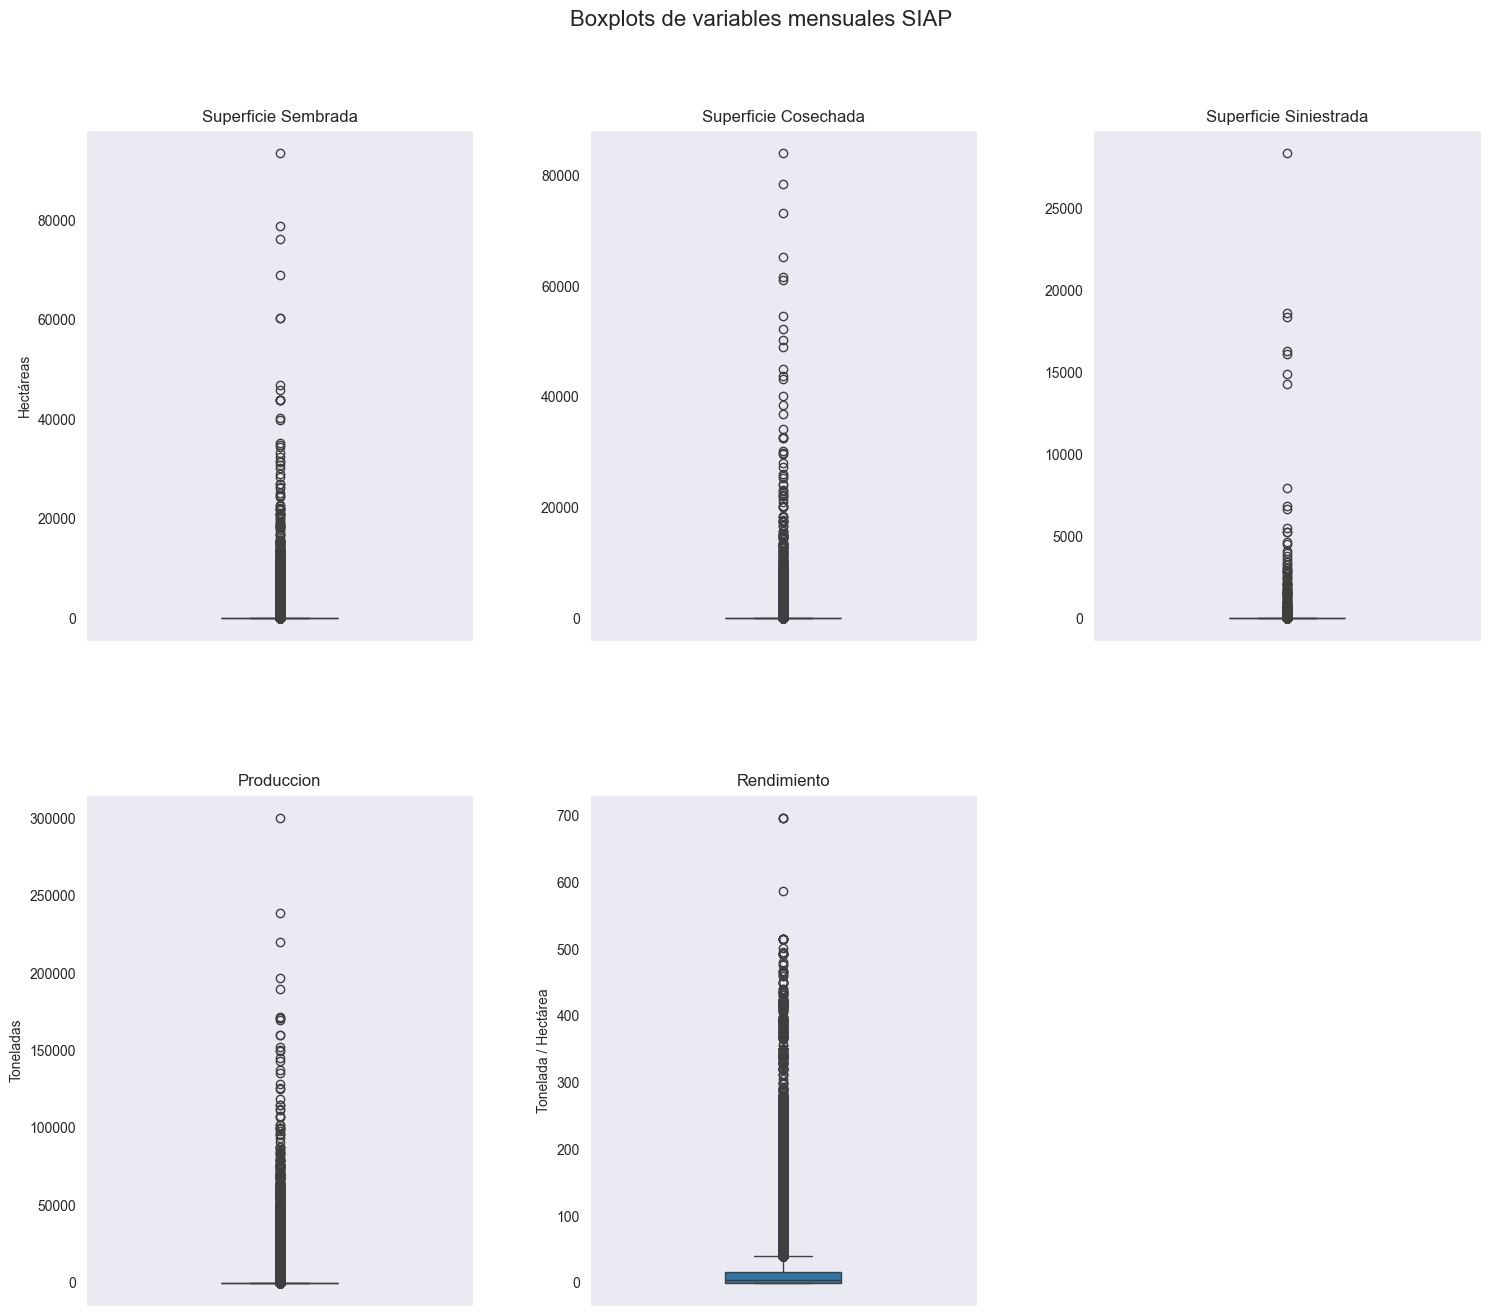

In [23]:
# Fijamos estilo
sns.set_style("dark")

# Configurar la figura y los subplots
num_rows = 2
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 12))
# Ajustar el espacio entre subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3, bottom=-0.1)

# Asegurarse de que 'axes' sea una matriz 2D
axes = axes.reshape(-1)

# Iterar a través de las columnas numéricas y crear boxplots divididos por HeartDisease
for i, variable in enumerate(VARIABLES_NUMERICAS_SIAP[:5]):
    sns.boxplot(data=df_siap, y=variable, ax=axes[i], width=0.3)
    axes[i].set_title(f'{variable}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Eliminar la subgráfica vacía 
fig.delaxes(axes[-1])

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables mensuales SIAP', fontsize=16)

axes[0].set_ylabel('Hectáreas')
axes[3].set_ylabel('Toneladas')
axes[4].set_ylabel('Tonelada / Hectárea')

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Mostrar la figura
plt.show()

#### Detección y eliminación de valores atípicos: *Local Factor Outlier*

In [24]:
# Crear modelo 
clf = LocalOutlierFactor(n_neighbors=20)

# Quitar columnas cualitativas 
X = df_siap.drop(columns=['Entidad', 'Municipio', 'Año', 'Mes', 'Cultivo'])

# Buscar outliers
estimado_LOF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_LOF = abs(estimado_LOF[estimado_LOF==-1].sum())
porcentaje_outliers_LOF = cantidad_outliers_LOF / len(df_siap) * 100

print(f"Cantidad de outliers: {cantidad_outliers_LOF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_LOF:.2f}%")

Cantidad de outliers: 29552
Porcentaje con respecto al total de datos: 7.82%


Inspeccionar algunos valores atípicos según el método *Local Factor Outlier*.

In [25]:
# Obtener datos outlier según LOF
outliers_LOF = df_siap[(estimado_LOF==-1)]

# Inspeccionar muestras de outliers
outliers_LOF.sample(n=10)

,Entidad,Municipio,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
619013,Puebla,Xochitlán de Vicente Suárez,3.13,0.00,0.0,0.00,0.00,2020,Mayo,Chile verde,0.00,0.0,0.0,0.00
194209,Hidalgo,Nicolás Flores,6.05,0.00,0.0,0.00,0.00,2022,Abril,Frijol,4.05,0.0,0.0,0.00
157053,Veracruz,Cosamaloapan de Carpio,42.20,0.00,0.0,0.00,0.00,2022,Enero,Mango,42.20,0.0,0.0,0.00
435060,Veracruz,Huatusco,186.00,16.00,0.0,20.00,1.25,2021,Junio,Frijol,167.00,0.0,0.0,0.00
670511,Morelos,Yecapixtla,6.50,0.00,0.0,0.00,0.00,2020,Agosto,Chile verde,0.50,0.0,0.0,0.00
223555,México,Tenango del Aire,2.00,0.00,0.0,0.00,0.00,2022,Junio,Calabacita,1.50,0.0,0.0,0.00
552871,Campeche,Calakmul,98.00,53.00,0.0,425.08,8.02,2021,Diciembre,Limón,0.00,1.0,0.0,27.54
245409,México,Ixtapan del Oro,227.65,13.65,0.0,21.95,1.61,2022,Julio,Frijol,205.57,0.0,0.0,0.00
171130,México,Xonacatlán,13.69,0.00,0.0,0.00,0.00,2022,Febrero,Nopalitos,0.00,0.0,0.0,0.00
322149,Campeche,Campeche,52.00,52.00,0.0,1278.00,24.58,2022,Noviembre,Chile verde,0.00,2.0,0.0,28.00


Eliminar los supuestos valores atípicos e inspeccionar el resultado.

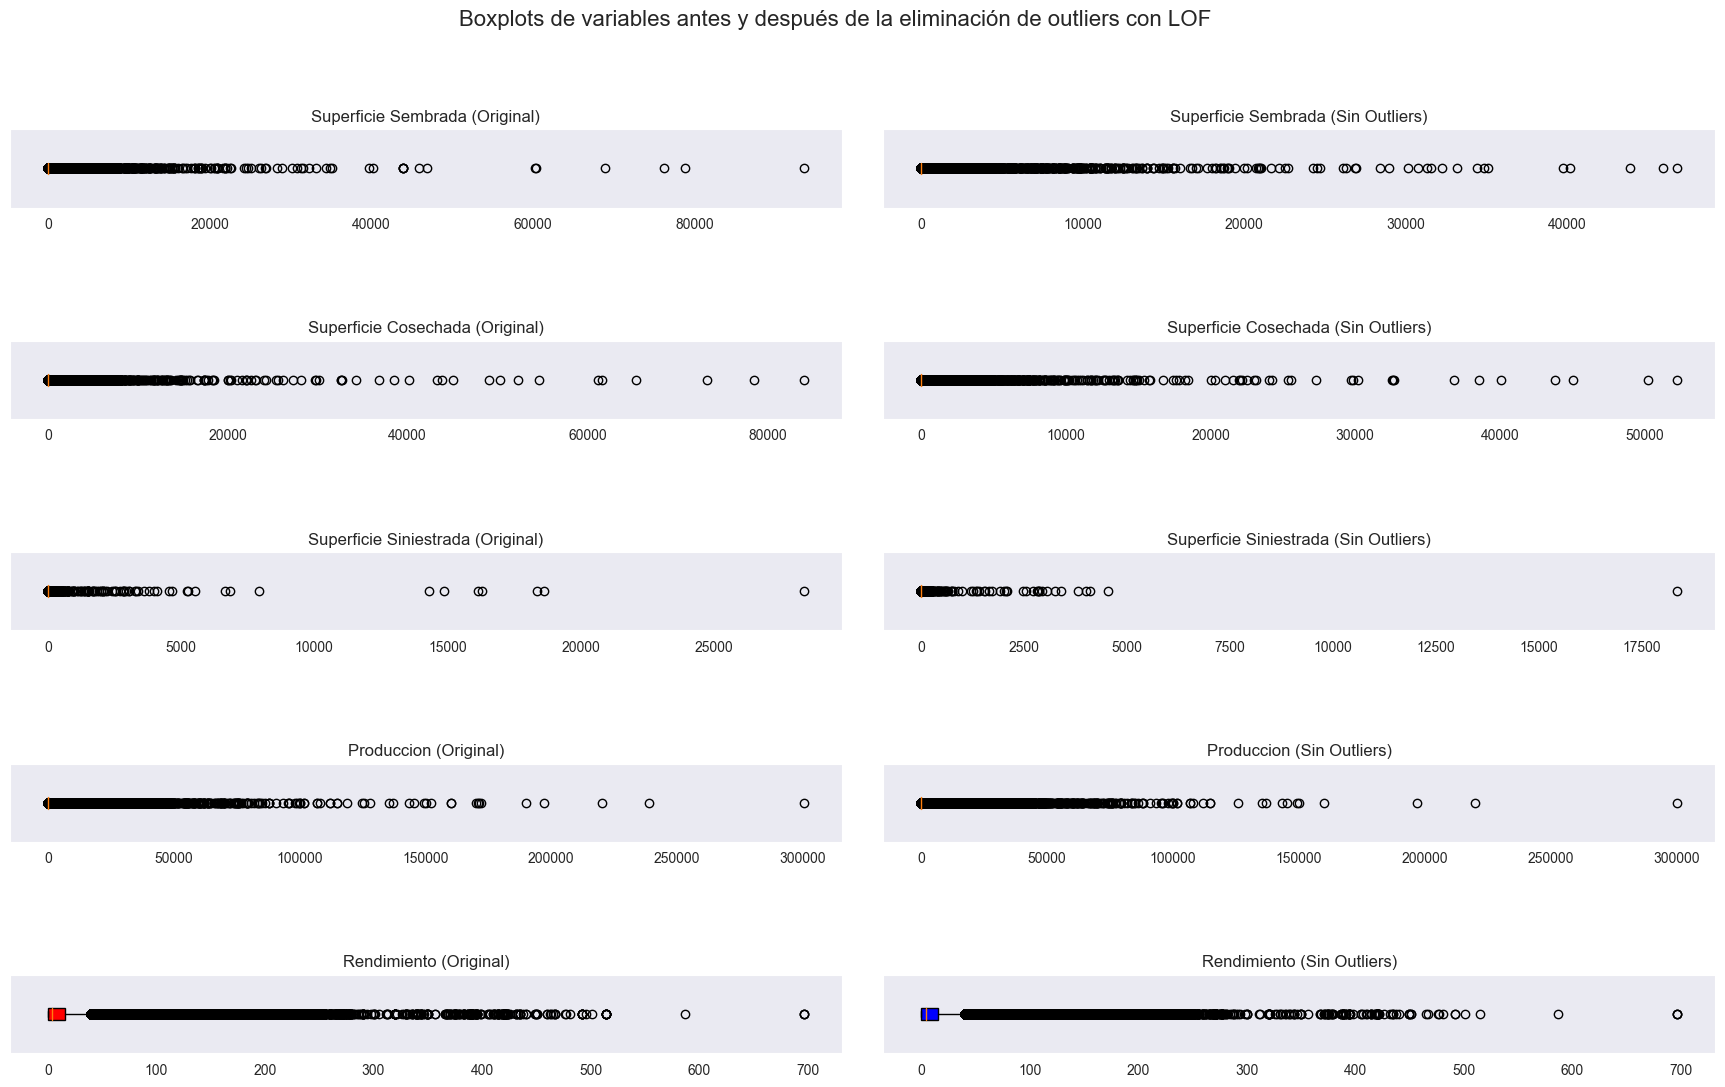

In [26]:
# Eliminar outliers del DataFrame
df_clean_LOF = df_siap[~(estimado_LOF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(22, 12))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS_SIAP[:5]):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_siap[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_LOF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables antes y después de la eliminación de outliers con LOF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=1.7, wspace=0.05)

# Mostrar la figura
plt.show()

#### Detección y eliminación de valores atípicos: *Isolation Forest*

In [27]:
# Crear modelo Isolation Forest
random_state = np.random.RandomState(42)
clf = IsolationForest(n_estimators=100,max_samples='auto',random_state=random_state)  # Puedes ajustar el parámetro de contaminación según tus necesidades

# Quitar columnas cualitativas 
X = df_siap.drop(columns=['Entidad', 'Municipio', 'Año', 'Mes', 'Cultivo'])

# Entrenar el modelo y predecir outliers
estimado_IF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_IF = len(estimado_IF[estimado_IF == -1])
porcentaje_outliers_IF = cantidad_outliers_IF / len(df_siap) * 100

print(f"Cantidad de outliers: {cantidad_outliers_IF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_IF:.2f}%")


Cantidad de outliers: 20338
Porcentaje con respecto al total de datos: 5.38%


Inspeccionar algunos valores atípicos según el método *Isolation Forest*.

In [28]:
# Obtener datos outlier según IF
outliers_IF = df_siap[(estimado_IF==-1)]

# Inspeccionar muestras de outliers
outliers_IF.sample(n=10)

,Entidad,Municipio,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
580295,Chiapas,Tumbalá,1021.00,850.00,0.0,331.50,0.39,2020,Febrero,Frijol,0.0,850.0,0.0,331.50
359348,Sonora,San Luis Río Colorado,921.00,0.00,0.0,0.00,0.00,2021,Enero,Brócoli,921.0,0.0,0.0,0.00
118821,Veracruz,Cotaxtla,1643.59,1643.59,0.0,28457.79,17.31,2023,Agosto,Limón,0.0,5.5,0.0,135.63
464271,Sonora,Caborca,7756.00,6652.00,0.0,81971.00,12.32,2021,Julio,Uva,0.0,2744.0,0.0,24001.00
69559,Oaxaca,San Dionisio Ocotepec,7.55,3.55,0.0,835.39,235.32,2023,Mayo,Tomate rojo (jitomate),4.0,0.0,0.0,238.81
682422,Puebla,Tepanco de López,71.50,22.00,0.0,4275.00,194.32,2020,Agosto,Tomate rojo (jitomate),0.0,11.0,0.0,2119.00
158571,Michoacán,La Huacana,240.00,227.00,0.0,563.09,2.48,2022,Enero,Papaya,240.0,227.0,0.0,563.09
137600,Zacatecas,Fresnillo,61210.00,0.00,16746.5,0.00,0.00,2023,Septiembre,Frijol,437.0,0.0,16146.5,0.00
157147,Chihuahua,Cuauhtémoc,10614.30,0.00,0.0,0.00,0.00,2022,Enero,Manzana,10614.3,0.0,0.0,0.00
216254,Sinaloa,Elota,801.00,801.00,0.0,44479.80,55.53,2022,Mayo,Pepino,0.0,0.0,0.0,0.00


Eliminar los supuestos valores atípicos e inspeccionar el resultado.

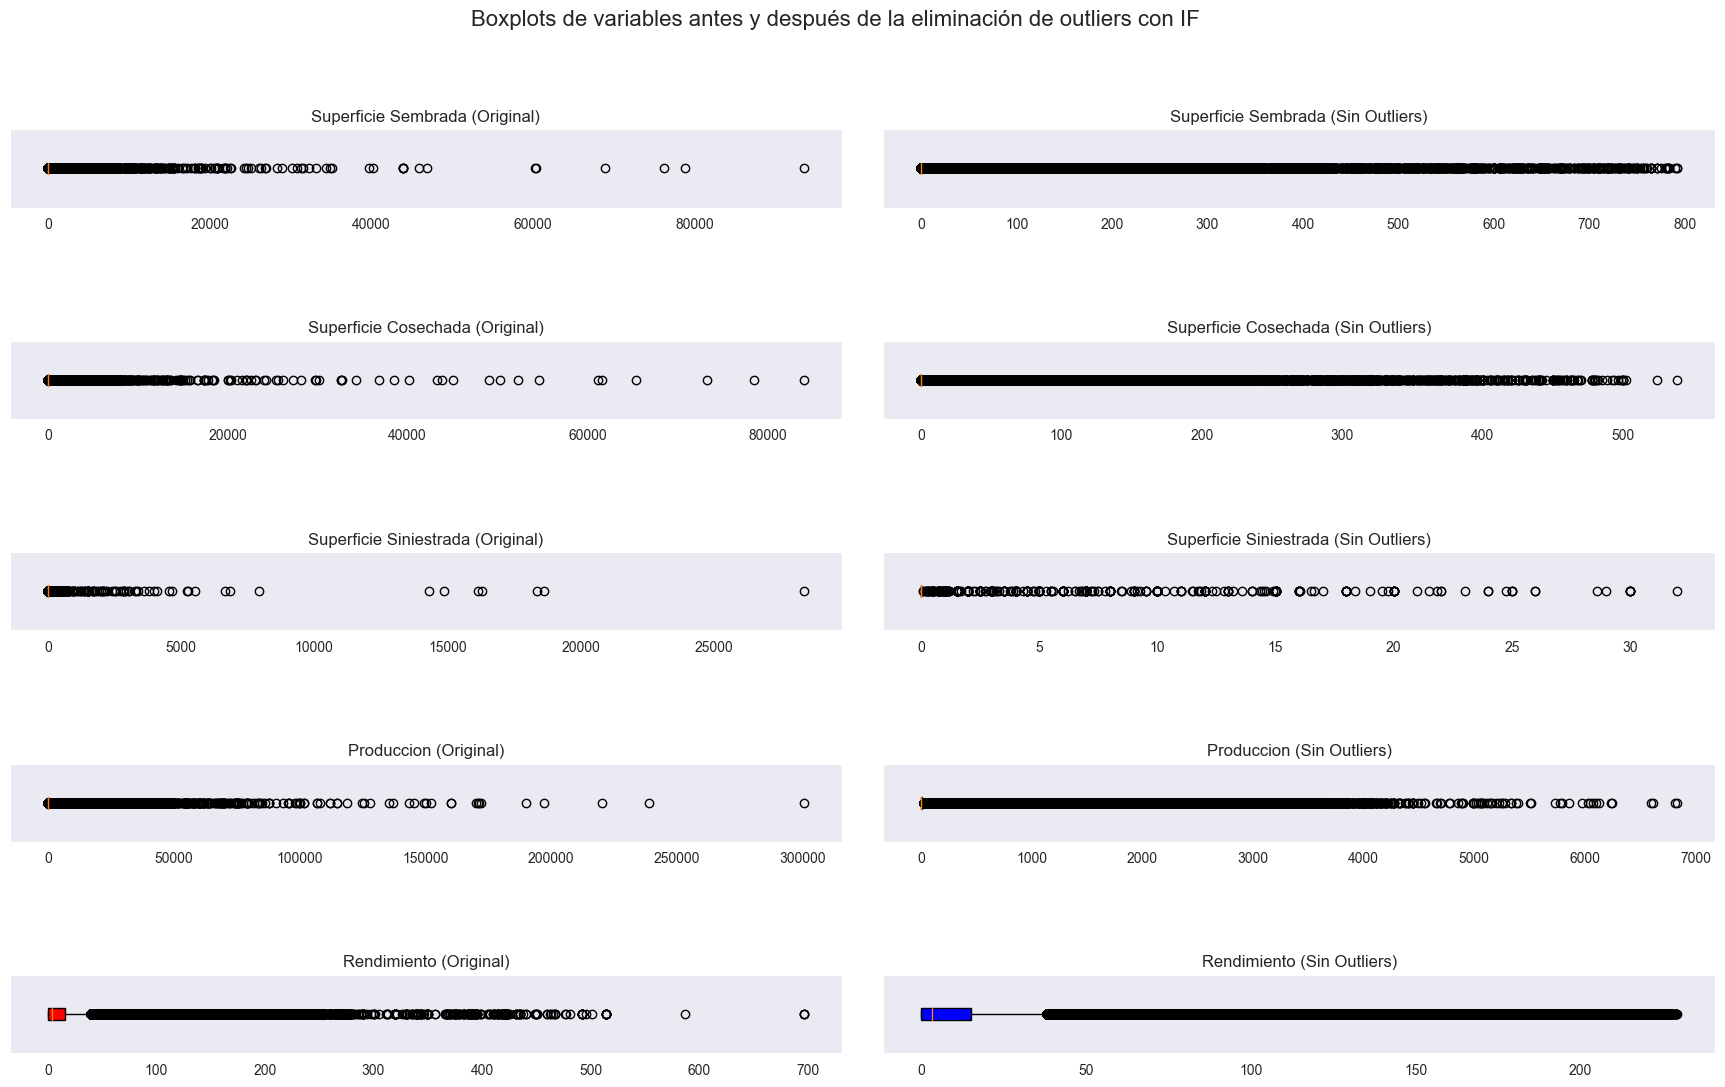

In [29]:
# Eliminar outliers del DataFrame
df_clean_IF = df_siap[~(estimado_IF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(22, 12))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS_SIAP[:5]):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_siap[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_IF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables antes y después de la eliminación de outliers con IF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=1.7, wspace=0.05)

# Mostrar la figura
plt.show()

En ambos casos, la inspección de los *outliers* putativos no nos permite identificarlos verdaderamente como valores atípicos. Es esperable que en ciertas épocas la producción de algunos cultivos incremente de manera significativa. Por esto y otros factores, decidimos conservar los putativos valores atípicos y continuar el EDA con el DataFrame completo.  

## SNIIM

#### Cargar datos

In [20]:
# Path al archivo parquet
url_sniim = r'C:\Users\jcbar\OneDrive\Documentos\Ingeniería de Características\Proyecto\Primera parte\Tidy\SNIIM.parquet'
# Cargar archivo parquet como DataFrame
df_sniim = pd.read_parquet(url_sniim)
# Inspeccionar primeros elementos del DataFrame
df_sniim.sample(n=5)

,Fecha,Presentacion,Origen,Destino,Precio Minimo,Precio Maximo,Precio Frecuente,Observacion,Cultivo
828287,21/12/2020,Caja de 20 kg.,Puebla,Veracruz: Mercado Malibrán,25.00,28.00,27.00,nan,tuna blanca_primera
99820,12/02/2020,Kilogramo,Nayarit,Nayarit: Mercado de abasto 'Adolfo López Mateo...,16.00,17.50,17.00,nan,cebolla bola grande_primera
75529,18/04/2022,Caja de 24 kg.,Distrito Federal,"Campeche: Mercado ""Pedro Sáinz de Baranda"", Ca...",8.33,9.17,9.17,nan,calabacita italiana_primera
244557,13/01/2023,Kilogramo,Zacatecas,Guerrero: Central de Abastos de Acapulco,110.00,110.00,110.00,nan,chile puya seco_primera
808669,06/02/2020,Kilogramo,Sinaloa,"Coahuila: Central de Abasto de La Laguna, Torreón",15.00,16.00,15.50,nan,tomate verde_primera


Los valores de precio están estandarizados a KG y por ende las columnas "Presentacion" y "Observacion" son remanentes que podemos eliminar

In [21]:
# Descartamos columnas Presentacion y Observacion
df_sniim = df_sniim.drop(['Presentacion', 'Observacion'], axis=1)

#### Dimensiones de los datos

In [22]:
# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_sniim.shape}")

Dimensión de los datos: (900763, 7)


#### Tipos de datos

In [23]:
# Tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_sniim.dtypes}\n")

Tipo de dato de cada variable:
 Fecha                object
Origen               object
Destino              object
Precio Minimo       float64
Precio Maximo       float64
Precio Frecuente    float64
Cultivo              object
dtype: object



Notamos que la variable *Fecha* es de tipo **object**, por lo que la convertimos a **datetime** para facilitar futuros análisis

#### Conversión de variable object a datetime

In [24]:
# Efectuar conversión especificando el formato específico de la fecha
df_sniim['Fecha'] = pd.to_datetime(df_sniim['Fecha'], format="%d/%m/%Y")
# Inspeccionar nuevamente el tipo de dato de cada variable
print(f"Tipo de dato de cada variable:\n {df_sniim.dtypes}\n")

Tipo de dato de cada variable:
 Fecha               datetime64[ns]
Origen                      object
Destino                     object
Precio Minimo              float64
Precio Maximo              float64
Precio Frecuente           float64
Cultivo                     object
dtype: object



#### Aplicar filtros

In [25]:
#Filtramos nuestro DataFrame solo para los años 2020 - 2023 
df_sniim = df_sniim[df_sniim['Fecha'].dt.year >= 2020]

Nota: *a causa de la diferencia en el nombre de los cultivos entre los DataFrames, el filtrado con los cultivos de interés de la Red BAMX se dejará para más adelante*.

#### Valores faltantes

In [26]:
# Valores faltantes
print(f"Valores faltantes:\n {df_sniim.isna().sum()}")

Valores faltantes:
 Fecha               0
Origen              0
Destino             0
Precio Minimo       0
Precio Maximo       0
Precio Frecuente    0
Cultivo             0
dtype: int64


No contamos con valores faltantes y por ende no hace falta manipulación alguna. 

### Homologar DataFrames

Antes de poder efectuar análisis conjuntos con estos DataFrames es necesario realizar cierto pre-procesamiento a los datos del SNIIM:

- Ajustar los nombres de los estados de Origen
- Ajustar los nombres de los cultivos
- Promediar los precios de manera mensual

#### Ajustar los nombres de los estados de Origen

In [27]:
# Evaluamos qué nombres de estado en el sniim no están en el siap
print('Estados del SNIIM no presentes en el SIAP:\n')
for estado_sniim in df_sniim['Origen'].unique():
    if estado_sniim not in df_siap['Entidad'].unique():
        print(estado_sniim)

Estados del SNIIM no presentes en el SIAP:



Distrito Federal
Importación
Nacional


Reemplazamos "Distrito Federal" por "Ciudad de México" tal como viene en el SIAP. Descartamos las filas con datos "Importación", "Nacional" y "Sin Especificar".

In [28]:
# Crear copia del dataframe
df_sniim_orig = df_sniim.copy()

# Reemplazamos Distrito Federal por Ciudad de México
condicion = df_sniim_orig['Origen'] == "Distrito Federal"
df_sniim_orig.loc[condicion, 'Origen'] = 'Ciudad de México' 

# Descartamos la filas cuyo valor en la columna "Origen" es Importación o Nacional
df_sniim_orig = df_sniim_orig[(df_sniim_orig['Origen'] != 'Importación') | (df_sniim_orig['Origen'] != 'Nacional') | (df_sniim_orig['Origen'] != 'Sin Especificar')]

#### Ajustar los nombres de los cultivos

Para esto debemos tomar como referencia la lista de cultivos ofrecida por el experto de la red BAMX.

In [29]:
# Inspeccionamos nuevamente algunos elementos de la lista de cultivos
CULTIVOS[:10]

['Tomate rojo (jitomate)',
 'Chile verde',
 'Limón',
 'Pepino',
 'Plátano',
 'Mango',
 'Garbanzo',
 'Brócoli',
 'Cebolla',
 'Sandía']

Ahora inspeccionamos los cultivos de los datos del SNIIM.

In [30]:
# Inspeccionar algunos nombres de cultivos
df_sniim['Cultivo'].sample(n=10)

703926                            piña chica_primera
324451                           col mediana_primera
594172    melón cantaloupe sin clasificación_primera
147830                           chile ancho_primera
430297                                  kiwi_primera
67446                     calabacita criolla_primera
540964                             mango oro_primera
735957                      plátano dominico_primera
312115            coliflor sin clasificación_primera
777305                         sandía rayada_primera
Name: Cultivo, dtype: object

El formato consiste en el nombre de los cultivos seguido por una descripción de la variedad.
Debido a que en el SIAP no se maneja variedad, para poder homologar los datos nos quedamos solamente con el nombre de los cultivos. No obstante, esto aplica solo para los cultivos cuyo nombre consiste en una sola palabra. Para los nombres con más palabras utilizamos un abordaje manual. 

In [31]:
# Nombres de cultivo con más de una palabra
[cultivo for cultivo in CULTIVOS if len(cultivo.split(' ')) > 1]

['Tomate rojo (jitomate)', 'Chile verde', 'Tomate verde', 'Toronja (pomelo)']

In [32]:
# Crear copia del DataFrame
df_sniim_orig_cult = df_sniim_orig.copy()

# Creamos una nueva columna en nuestro DataFrame para almacenar los nuevos nombres de los cultivos
df_sniim_orig_cult['Cultivo SIAP'] = df_sniim_orig_cult['Cultivo']

# Tomate rojo (jitomate): reemplazamos los cultivos "tomate bola_primera" y "tomate saladette_primera"

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'].isin(['tomate bola_primera', 'tomate saladette_primera'])

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Tomate rojo (jitomate)'

# Tomate verde: reemplazamos el cultivo "tomate verde_primera"

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'] == 'tomate verde_primera'

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Tomate verde'

# Toronja (pomelo): reemplazamos el cultivo "toronja blanca_primera", "toronja roja mediana_primera", "toronja roja_primera" y "toronja rosada_primera"

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'].isin(["toronja blanca_primera", "toronja roja mediana_primera", "toronja roja_primera", "toronja rosada_primera"])

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Toronja (pomelo)'

# Chile verde: reemplazamos el cultivo 'chile anaheim_primera', 'chile california_primera', 'chile chilaca_primera', 'chile serrano_primera', 'chile poblano_primera', 'chile jalapeño_primera' y 'chile habanero_primera'

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'].isin(['chile anaheim_primera', 'chile california_primera', 'chile chilaca_primera', 'chile serrano_primera', 'chile poblano_primera',
                                       'chile jalapeño_primera', 'chile habanero_primera'])

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Chile verde'

# Nopalitos: en el SNIIM vienen solamente como Nopal

# Seleccionar filas que cumplan con la condición
condicion = df_sniim_orig_cult['Cultivo SIAP'].isin(['nopal grande_primera', 'nopal_primera'])

# Modificar los valores en esas filas
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = 'Nopalitos'

Podemos automatizar el ajuste de los nombres de cultivo con una sola palabra utilizando expresiones regulares

In [33]:
# Condición para ignorar los cultivos que ya modificamos
condicion = ~df_sniim_orig_cult['Cultivo SIAP'].isin(['Tomate rojo (jitomate)', 'Tomate verde', 'Toronja (pomelo)', 'Nopalitos', 'Chile verde'])

# Expresión regular para capturar la primera palabra
pattern = r'^([^\W_]+)'

# Aplicar la expresión regular para mantener solo la primera palabra
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = df_sniim_orig_cult[condicion]['Cultivo SIAP'].str.extract(pattern).values

# Reemplazar la primera letra por mayúscula
df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'] = df_sniim_orig_cult.loc[condicion, 'Cultivo SIAP'].str.title()

# Inspeccionar nuevamente algunos nombres de cultivos
df_sniim_orig_cult['Cultivo SIAP'].sample(n=10)

22307         Ajo
344285      Ejote
652716     Papaya
858803        Uva
665400       Papa
832423       Tuna
40721        Apio
728519    Plátano
2185       Acelga
495507      Limón
Name: Cultivo SIAP, dtype: object

Utilizar nuevamente la lista de cultivos para filtrar el DataFrame

In [34]:
# Filtramos el DataFrame para quedarnos solo con los cultivos de interés
df_sniim_orig_cult = df_sniim_orig_cult[df_sniim_orig_cult['Cultivo SIAP'].isin(CULTIVOS)]

# Dimensión de nuestros datos
print(f"Dimensión de los datos: {df_sniim_orig_cult.shape}")

# Inspeccionamos el DataFrame
df_sniim_orig_cult.sample(n=5)

Dimensión de los datos: (334540, 8)


,Fecha,Origen,Destino,Precio Minimo,Precio Maximo,Precio Frecuente,Cultivo,Cultivo SIAP
810172,2022-03-16,Baja California,"Baja California : Central de Abasto INDIA, Tij...",12.24,12.24,12.24,tomate verde_primera,Tomate verde
120324,2023-02-08,Baja California,Baja California Sur: Unión de Comerciantes de ...,20.00,40.00,40.00,cebolla morada_primera,Cebolla
809434,2021-03-29,Baja California,Baja California Sur: Unión de Comerciantes de ...,10.00,30.00,10.00,tomate verde_primera,Tomate verde
674432,2022-08-11,Veracruz,Veracruz: Central de Abasto de Jalapa,27.08,27.50,27.50,papa san josé_primera,Papa
80946,2022-03-25,Yucatán,Yucatán: Centro Mayorista Oxkutzcab,6.00,6.00,6.00,calabacita regional_primera,Calabacita


Debido a la manipulación que realizamos con los cultivos del SNIIM para homologarlos con los del SIAP, es posible que un mismo cultivo presente distintos precios para una misma fecha y mercado. Para abordar esto, identificamos los casos en los que estos sucede y promediamos los precios.

In [35]:
# Agrupar por Fecha, Origen y Destino
df_sniim_orig_cult = df_sniim_orig_cult.groupby(["Fecha", "Origen", "Destino", "Cultivo SIAP"])[["Precio Minimo", "Precio Maximo", "Precio Frecuente"]].mean().reset_index()

# Inspeccionar resultado
df_sniim_orig_cult.sample(n=5)

,Fecha,Origen,Destino,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente
181788,2022-07-11,Campeche,"Campeche: Mercado ""Pedro Sáinz de Baranda"", Ca...",Naranja,1.20,1.400,1.40
112030,2021-08-05,Chiapas,Aguascalientes: Centro Comercial Agropecuario ...,Mango,12.00,12.835,12.50
133361,2021-11-19,Quintana Roo,"Quintana Roo: Mercado de Chetumal, Quintana Roo",Uva,90.00,90.000,90.00
153444,2022-02-25,Veracruz,Veracruz: Mercado Malibrán,Plátano,14.00,20.000,17.00
165725,2022-04-27,Importación,Sonora: Central de Abasto de Cd. Obregón,Melón,28.17,28.170,28.17


#### Definimos constantes

In [36]:
VARIABLES_NUMERICAS_SNIIM = ["Precio Minimo", "Precio Maximo", "Precio Frecuente"]

##### Promedio mensual de precios SNIIM

In [37]:
# Crear copia del DataFrame
df_sniim_orig_cult_mes = df_sniim_orig_cult.copy()

# Desglosar la columna Fecha en dos columnas adicionales para el año y el mes
df_sniim_orig_cult_mes['Año'] = df_sniim_orig_cult_mes['Fecha'].dt.year
df_sniim_orig_cult_mes['Mes'] = df_sniim_orig_cult_mes['Fecha'].dt.month

# Agrupar por Año, Mes, Origen, Destino y Cultivo SIAP, y calcular el promedio de los precios
df_sniim_dest_orig_cult_mens = df_sniim_orig_cult_mes.groupby(['Año', 'Mes', 'Origen', 'Cultivo SIAP'])[['Precio Minimo', 'Precio Maximo', 'Precio Frecuente']].mean().round(2).reset_index()

# Diccionario para mapear números de mes a nombres de mes
meses_dict = {
    1: 'Enero',
    2: 'Febrero',
    3: 'Marzo',
    4: 'Abril',
    5: 'Mayo',
    6: 'Junio',
    7: 'Julio',
    8: 'Agosto',
    9: 'Septiembre',
    10: 'Octubre',
    11: 'Noviembre',
    12: 'Diciembre'
}

# Aplicar el mapeo a la columna 'Mes'
df_sniim_orig_cult_mes['Mes'] = df_sniim_orig_cult_mes['Mes'].map(meses_dict)

# DataFrame resultante
df_sniim_orig_cult_mes

,Fecha,Origen,Destino,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente,Año,Mes
0,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Brócoli,12.00,14.00,13.00,2020,Enero
1,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Calabacita,11.33,12.67,12.00,2020,Enero
2,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Coliflor,13.00,15.00,14.00,2020,Enero
3,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Guayaba,8.75,9.58,9.17,2020,Enero
4,2020-01-02,Aguascalientes,Aguascalientes: Centro Comercial Agropecuario ...,Lechuga,6.00,8.00,7.00,2020,Enero
...,...,...,...,...,...,...,...,...,...
286031,2023-10-25,Veracruz,Veracruz: Mercado Malibrán,Plátano,13.00,19.50,15.00,2023,Octubre
286032,2023-10-25,Yucatán,"Quintana Roo: Mercado de Chetumal, Quintana Roo",Naranja,21.00,21.00,21.00,2023,Octubre
286033,2023-10-25,Yucatán,"Quintana Roo: Mercado de Chetumal, Quintana Roo",Uva,120.00,120.00,120.00,2023,Octubre
286034,2023-10-25,Zacatecas,Aguascalientes: Centro Comercial Agropecuario ...,Tomate verde,6.00,8.00,7.00,2023,Octubre


El DataFrame con los datos del SNIIM promediados mensualmente será utilizado específicamente para los análisis conjuntos con los datos del SIAP. Para análsis individuales, se utilizarán los datos del SNIIM que mantienen los precios diarios.

### Valores atípicos

Descripción estadística general de las variables para una inspección visual de la posible presencia de valores atípicos.

In [38]:
# Descripción de variables numéricas
df_sniim_orig_cult.drop(columns='Fecha', axis=1).describe().round(2)

,Precio Minimo,Precio Maximo,Precio Frecuente
count,286036.00,286036.00,286036.00
mean,27.53,30.89,29.35
std,33.15,35.08,34.26
min,0.25,0.35,0.30
25%,12.00,13.50,12.63
50%,16.67,20.00,18.00
75%,30.00,34.44,32.00
max,390.00,390.00,390.00


No se observan anormalidades como valores negativos o precios muy extremos.


#### Dispersión de los datos

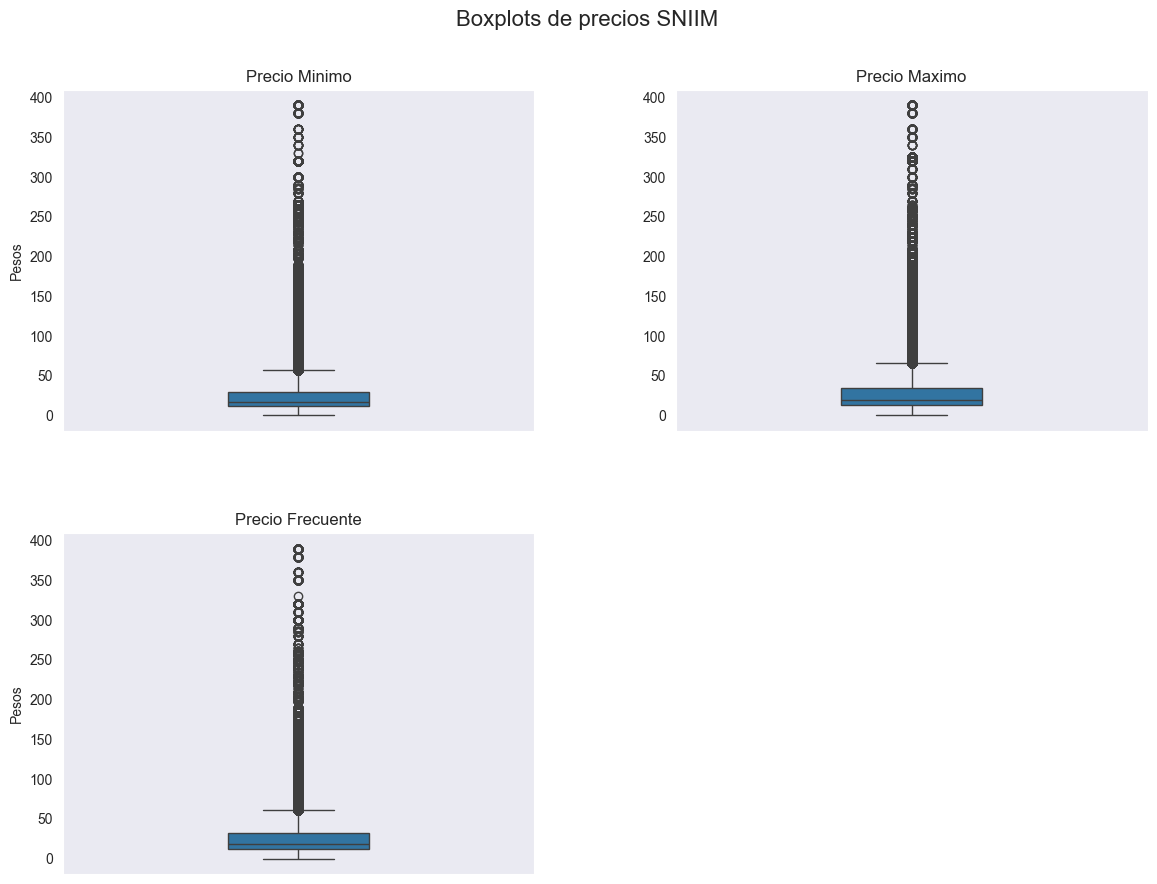

In [49]:
# Fijamos estilo
sns.set_style("dark")

# Configurar la figura y los subplots
num_rows = 2
num_cols = 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(14, 8))
# Ajustar el espacio entre subplots
fig.subplots_adjust(wspace=0.3, hspace=0.3, bottom=-0.1)

# Asegurarse de que 'axes' sea una matriz 2D
axes = axes.reshape(-1)

# Iterar a través de las columnas numéricas y crear boxplots divididos por HeartDisease
for i, variable in enumerate(VARIABLES_NUMERICAS_SNIIM):
    sns.boxplot(data=df_sniim_orig_cult, y=variable, ax=axes[i], width=0.3)
    axes[i].set_title(f'{variable}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Eliminar la subgráfica vacía 
fig.delaxes(axes[-1])

# Agregar un título general a la figura
fig.suptitle('Boxplots de precios SNIIM', fontsize=16)

axes[0].set_ylabel('Pesos')
axes[2].set_ylabel('Pesos')

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Mostrar la figura
plt.show()

#### Detección y eliminación de valores atípicos: *Local Factor Outlier*

In [50]:
# Crear modelo 
clf = LocalOutlierFactor(n_neighbors=20)

# Quitar columnas cualitativas 
X = df_sniim_orig_cult.drop(columns=['Fecha', 'Origen', 'Destino', 'Cultivo SIAP'])

# Buscar outliers
estimado_LOF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_LOF = abs(estimado_LOF[estimado_LOF==-1].sum())
porcentaje_outliers_LOF = cantidad_outliers_LOF / len(df_sniim_orig_cult) * 100

print(f"Cantidad de outliers: {cantidad_outliers_LOF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_LOF:.2f}%")

Cantidad de outliers: 25717
Porcentaje con respecto al total de datos: 8.99%


Inspeccionar algunos valores atípicos según el método *Isolation Forest*.

In [51]:
# Obtener datos outlier según LOF
outliers_LOF = df_sniim_orig_cult[(estimado_LOF==-1)]

# Inspeccionar muestras de outliers
outliers_LOF.sample(n=10)

,Fecha,Origen,Destino,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente
34865,2020-05-22,Sonora,Chihuahua: Central de Abasto de Chihuahua,Chile verde,17.000,24.000,22.500
92818,2021-05-11,Guerrero,Aguascalientes: Centro Comercial Agropecuario ...,Mango,18.000,18.670,18.330
184604,2022-07-22,Importación,Jalisco: Mercado de Abasto de Guadalajara,Durazno,34.380,35.630,34.380
265462,2023-07-26,Sinaloa,Chihuahua: Central de Abasto de Chihuahua,Lechuga,11.670,17.500,14.790
201580,2022-10-14,Jalisco,"Sonora: Mercado de Abasto ""Francisco I. Madero...",Coliflor,30.000,31.250,31.250
198172,2022-09-28,Coahuila,México: Central de Abasto de Toluca,Melón,17.825,19.615,19.615
127584,2021-10-20,Importación,Jalisco: Mercado Felipe Ángeles de Guadalajara,Uva,59.920,59.920,59.920
172577,2022-05-30,Guerrero,México: Central de Abasto de Toluca,Mango,12.500,14.060,12.500
33316,2020-05-18,Puebla,Chiapas: Central de Abasto de Tuxtla Gutiérrez,Limón,10.000,11.050,10.000
226185,2023-02-13,Puebla,DF: Central de Abasto de Iztapalapa DF,Lechuga,13.330,20.830,14.170


Eliminar los supuestos valores atípicos e inspeccionamos el resultado.

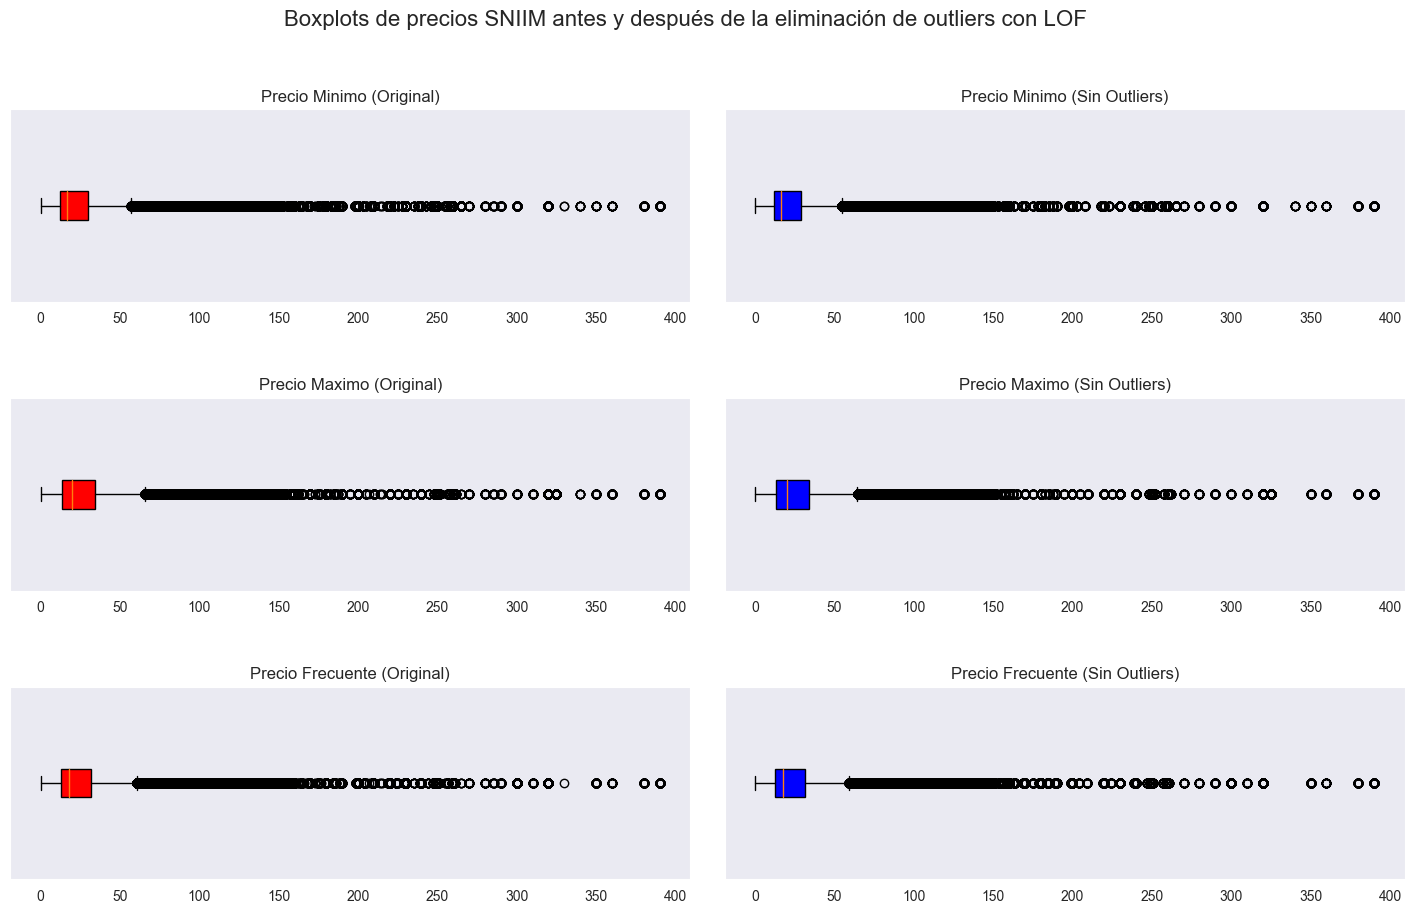

In [52]:
# Eliminar outliers del DataFrame
df_clean_LOF = df_sniim_orig_cult[~(estimado_LOF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS_SNIIM):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_sniim_orig_cult[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_LOF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de precios SNIIM antes y después de la eliminación de outliers con LOF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=.5, wspace=0.05)

# Mostrar la figura
plt.show()

#### Detección y eliminación de valores atípicos: *Isolation Forest*

In [53]:
# Crear modelo Isolation Forest
random_state = np.random.RandomState(42)
clf = IsolationForest(n_estimators=100,max_samples='auto',random_state=random_state)  # Puedes ajustar el parámetro de contaminación según tus necesidades

# Quitar columnas cualitativas 
X = df_sniim_orig_cult.drop(columns=['Fecha', 'Origen', 'Destino', 'Cultivo SIAP'])

# Entrenar el modelo y predecir outliers
estimado_IF = clf.fit_predict(X)

# Contar y mostrar resultados
cantidad_outliers_IF = len(estimado_IF[estimado_IF == -1])
porcentaje_outliers_IF = cantidad_outliers_IF / len(df_sniim_orig_cult) * 100

print(f"Cantidad de outliers: {cantidad_outliers_IF}")
print(f"Porcentaje con respecto al total de datos: {porcentaje_outliers_IF:.2f}%")

Cantidad de outliers: 48582
Porcentaje con respecto al total de datos: 16.98%


Inspeccionar algunos valores atípicos según el método Isolation Forest.

In [54]:
# Obtener datos outlier según IF
outliers_IF = df_sniim_orig_cult[(estimado_IF==-1)]

# Inspeccionar muestras de outliers
outliers_IF.sample(n=20)

,Fecha,Origen,Destino,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente
194830,2022-09-09,Jalisco,Colima: Centros de distribución de Colima,Fresa,120.000,140.000,140.000
222398,2023-01-27,Campeche,"Campeche: Mercado ""Pedro Sáinz de Baranda"", Ca...",Chile verde,55.000,60.000,60.000
205987,2022-11-08,Nuevo León,Tamaulipas: Módulo de Abasto de Reynosa,Uva,68.000,75.000,68.000
143733,2022-01-11,Jalisco,Colima: Centros de distribución de Colima,Fresa,50.000,65.000,65.000
267017,2023-08-02,Importación,"Nuevo León: Mercado de Abasto ""Estrella"" de Sa...",Uva,47.780,55.560,52.220
32086,2020-05-13,Importación,Jalisco: Mercado de Abasto de Guadalajara,Uva,70.000,71.875,70.000
77827,2021-02-25,Sonora,"Sonora: Mercado de Abasto ""Francisco I. Madero...",Uva,55.000,60.000,60.000
156611,2022-03-14,Ciudad de México,DF: Central de Abasto de Iztapalapa DF,Nopalitos,0.400,0.600,0.500
44827,2020-09-09,Nayarit,Nayarit: Mercado de abasto 'Adolfo López Mateo...,Uva,82.000,84.000,83.000
116453,2021-08-25,Veracruz,Chiapas: Central de Abasto de Tuxtla Gutiérrez,Naranja,2.000,2.200,2.000


Eliminar los supuestos valores atípicos e inspeccionar el resultado.

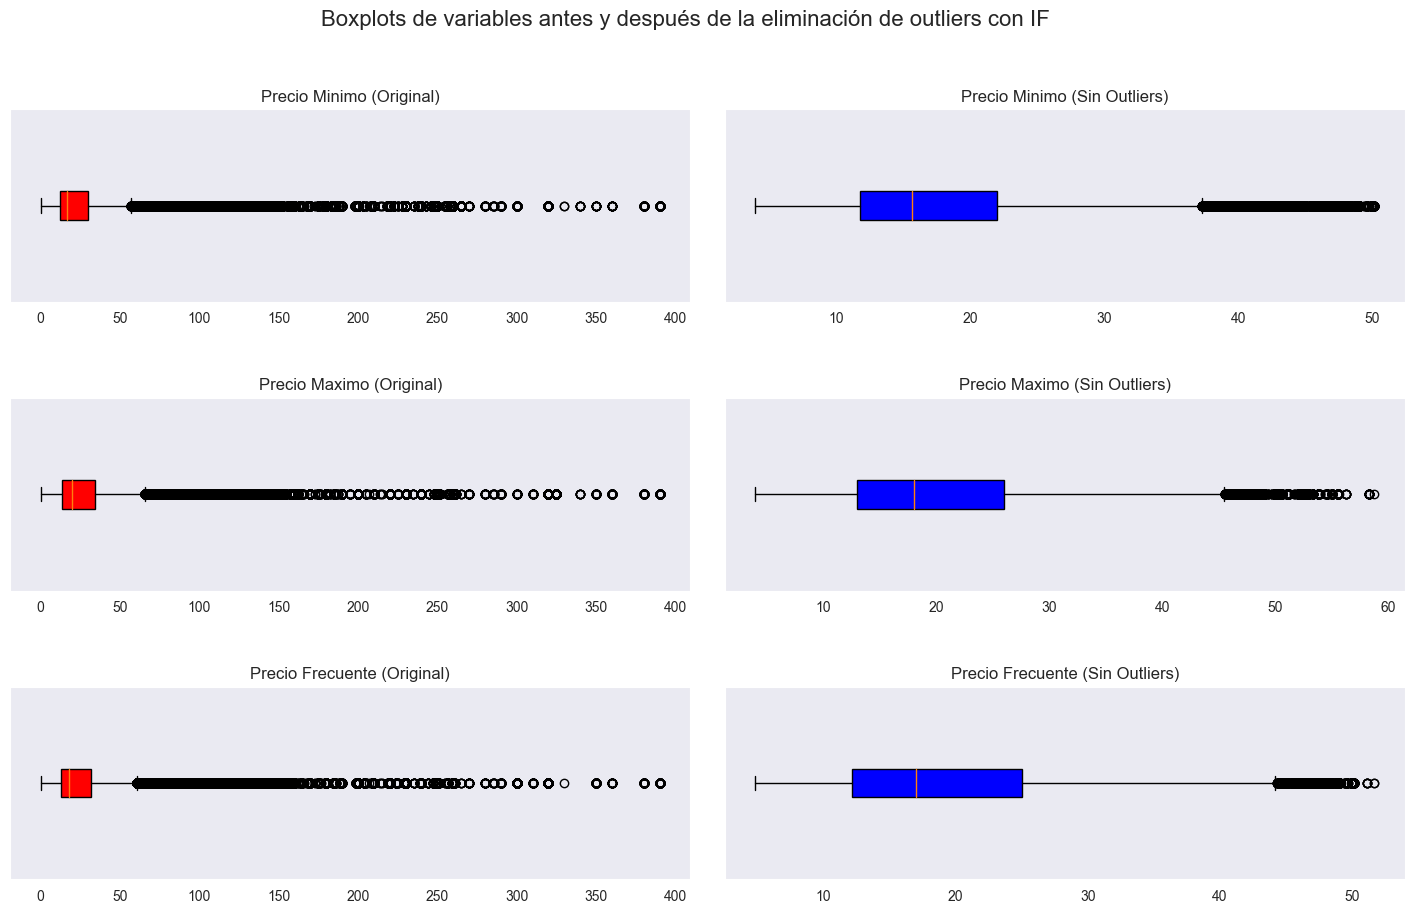

In [55]:
# Eliminar outliers del DataFrame
df_clean_IF = df_sniim_orig_cult[~(estimado_IF==-1)]

# Configurar la figura y los subplots con orientación horizontal
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))

# Iterar a través de las columnas numéricas y crear boxplots horizontales
for i, variable in enumerate(VARIABLES_NUMERICAS_SNIIM):
    # Boxplot original en rojo con relleno rojo
    axes[i, 0].boxplot(df_sniim_orig_cult[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='red'))
    axes[i, 0].set_title(f'{variable} (Original)')

    # Boxplot sin outliers en azul con relleno azul
    axes[i, 1].boxplot(df_clean_IF[variable], vert=False, patch_artist=True, boxprops=dict(facecolor='blue'))
    axes[i, 1].set_title(f'{variable} (Sin Outliers)')

    # Eliminar las etiquetas en la columna de la derecha
    axes[i, 0].set_yticklabels([])
    axes[i, 1].set_yticklabels([])

# Ajustar el espaciado entre subplots
#plt.tight_layout()

# Agregar un título general a la figura
fig.suptitle('Boxplots de variables antes y después de la eliminación de outliers con IF', fontsize=16)

# Ajustar el espaciado entre subplots verticalmente
plt.subplots_adjust(hspace=0.5, wspace=0.05)

# Mostrar la figura
plt.show()

En ambos casos, la inspección de los *outliers* putativos no nos permite identificarlos como verdaderamente valores atípicos. Es normal que ciertos cultivos, como la nuez, se mantengan con precios muy por encima de otros cultivos. Por esto y otros factores, decidimos conservar los putativos valores atípicos y continuar el EDA con el DataFrame completo.  

### Juntar DataFrames

Debido al no empatamiento de las variables *Municipio*, por parte de los datos del SIAP, y *Destino* por parte de los datos del SNIIM, decidimos eliminar estas variables antes de juntar los DataFrames.

In [39]:
# Descartamos la columna Municipio y sumamos aquellos valores que coincidan en Fecha, Estado y Cultivo
df_siap_mun = df_siap.groupby(['Año', 'Mes', 'Entidad', 'Cultivo'])[['Superficie Sembrada Acumulada', 'Superficie Cosechada Acumulada',
                                                                     'Superficie Siniestrada Acumulada', 'Produccion Acumulada',
                                                                     'Rendimiento', 'Superficie Sembrada','Superficie Cosechada', 'Superficie Siniestrada', 'Produccion']].sum().reset_index()

# Descartamos la columna Destino y sumamos aquellos valores que coincidan en Fecha, Estado y Cultivo
df_sniim_orig_cult_mes_dest = df_sniim_orig_cult_mes.groupby(['Año', 'Mes', 'Origen', 'Cultivo SIAP'])[df_sniim_orig_cult_mes.columns[4:7]].sum().reset_index()

#### Inspeccionar resultados

In [40]:
# Inspeccionamos los resultados 
df_siap_mun.head()

,Año,Mes,Entidad,Cultivo,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
0,2020,Enero,Aguascalientes,Berenjena,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
1,2020,Enero,Aguascalientes,Brócoli,440.0,0.0,0.0,0.0,0.00,440.0,0.0,0.0,0.0
2,2020,Enero,Aguascalientes,Calabacita,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0
3,2020,Enero,Aguascalientes,Cebolla,247.0,7.0,0.0,128.0,18.29,247.0,7.0,0.0,128.0
4,2020,Enero,Aguascalientes,Chile verde,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0


In [41]:
# Inspeccionamos los resultados 
df_sniim_orig_cult_mes_dest.head()

,Año,Mes,Origen,Cultivo SIAP,Precio Minimo,Precio Maximo,Precio Frecuente
0,2020,Abril,Aguascalientes,Brócoli,190.00,222.00,206.00
1,2020,Abril,Aguascalientes,Calabacita,1377.25,1456.51,1420.80
2,2020,Abril,Aguascalientes,Coliflor,176.00,216.00,196.00
3,2020,Abril,Aguascalientes,Guayaba,166.60,183.40,175.00
4,2020,Abril,Aguascalientes,Lechuga,114.00,140.25,126.75


#### Merge de los DataFrames

In [42]:
# Realizar el merge
df_merge = pd.merge(
    df_siap_mun,
    df_sniim_orig_cult_mes_dest,
    how='inner',
    left_on=['Año', 'Mes', 'Entidad', 'Cultivo'],
    right_on=['Año', 'Mes', 'Origen', 'Cultivo SIAP']
)

# Eliminar las columnas duplicadas
df_merge = df_merge.drop(['Origen', 'Cultivo SIAP'], axis=1)

# Mostrar el DataFrame resultante
df_merge

,Año,Mes,Entidad,Cultivo,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion,Precio Minimo,Precio Maximo,Precio Frecuente
0,2020,Enero,Aguascalientes,Brócoli,440.0,0.0,0.0,0.0,0.00,440.0,0.0,0.0,0.0,246.00,290.00,268.00
1,2020,Enero,Aguascalientes,Calabacita,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,1147.76,1232.18,1199.57
2,2020,Enero,Aguascalientes,Coliflor,152.0,0.0,0.0,0.0,0.00,152.0,0.0,0.0,0.0,265.00,309.00,287.00
3,2020,Enero,Aguascalientes,Guayaba,6187.9,0.0,0.0,0.0,0.00,6187.9,0.0,0.0,0.0,192.50,210.85,201.65
4,2020,Enero,Aguascalientes,Lechuga,1468.0,650.0,0.0,23946.0,36.84,1468.0,650.0,0.0,23946.0,118.00,162.00,140.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8418,2023,Octubre,Zacatecas,Cebolla,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,510.00,646.00,646.00
8419,2023,Octubre,Zacatecas,Chile verde,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,458.80,536.80,502.60
8420,2023,Octubre,Zacatecas,Lechuga,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,219.00,219.00,219.00
8421,2023,Octubre,Zacatecas,Tomate verde,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,176.00,228.00,207.00


#### Guardado de datos en formato parquet

Crear carpeta Tidy

In [43]:
# Crear carpeta Tidy
if not os.path.exists(r'Tidy_preprocessed'):
    os.mkdir("Tidy_preprocessed")

#### SIAP

Eliminar supuestas columnas duplicadas.

In [48]:
# Identificar columnas duplicadas
duplicates = df_siap.columns[df_siap.columns.duplicated()]

# Mostrar las columnas duplicadas
print("Columnas duplicadas:", duplicates)

# Eliminar columnas duplicadas
df_siap = df_siap.loc[:, ~df_siap.columns.duplicated()]


Columnas duplicadas: Index([], dtype='object')


Inspeccionar resultado

In [50]:
df_siap.head()

,Entidad,Municipio,Superficie Sembrada Acumulada,Superficie Cosechada Acumulada,Superficie Siniestrada Acumulada,Produccion Acumulada,Rendimiento,Año,Mes,Cultivo,Superficie Sembrada,Superficie Cosechada,Superficie Siniestrada,Produccion
0,Baja California Sur,La Paz,8.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,8.0,0.0,0.0,0.0
1,Baja California Sur,Los Cabos,3.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,3.0,0.0,0.0,0.0
2,Morelos,Miacatlán,0.4,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,0.4,0.0,0.0,0.0
3,Nayarit,Santiago Ixcuintla,60.0,0.0,0.0,0.0,0.0,2020,Enero,Berenjena,60.0,0.0,0.0,0.0
4,Quintana Roo,Bacalar,12.5,10.0,0.0,49.0,4.9,2020,Enero,Berenjena,12.5,10.0,0.0,49.0


In [51]:
# Si aún no existe, guardamos el DataFrame en un parquet
if not os.path.exists('Tidy_preprocessed/SIAP_preprocessed.parquet'):
    name = "SIAP_preprocessed"
    ruta_completa = os.path.join("Tidy_preprocessed/",name)
    df_siap.to_parquet(ruta_completa + '.parquet', index=False)

#### SNIIM precios diarios

In [52]:
# Si aún no existe, guardamos el DataFrame en un parquet
if not os.path.exists('Tidy_preprocessed/SNIIM_preprocessed_diario.parquet'):
    name = "SNIIM_preprocessed_diario"
    ruta_completa = os.path.join("Tidy_preprocessed/",name)
    df_sniim_orig_cult.to_parquet(ruta_completa + '.parquet', index=False)

#### SNIIM precios mensuales

In [53]:
# Si aún no existe, guardamos el DataFrame en un parquet
if not os.path.exists('Tidy_preprocessed/SNIIM_preprocessed_mensual.parquet'):
    name = "SNIIM_preprocessed_mensual"
    ruta_completa = os.path.join("Tidy_preprocessed/",name)
    df_sniim_orig_cult_mes.to_parquet(ruta_completa + '.parquet', index=False)

#### Merged dataframes

In [54]:
# Si aún no existe, guardamos el DataFrame en un parquet
if not os.path.exists('Tidy_preprocessed/SIAP_SNIIM_preprocessed.parquet'):
    name = "SIAP_SNIIM_preprocessed"
    ruta_completa = os.path.join("Tidy_preprocessed/",name)
    df_merge.to_parquet(ruta_completa + '.parquet', index=False)